In [ ]:
# Plug in the data in the first line under 'Data' (dataframe csv)
# (e.g. df_test.to_csv('HMM_11feb_SPY_2state_diff_vix_5y.csv') after calculating the hidden states in the other notebook)
# Main logic of the strategy is in TestStrategy -> next()
# In the main loop, try setting stdstats = True for a detailed graph (doesn't work for me - I get memory errors (aparently a known bug))
# cerebro = bt.Cerebro(stdstats=False)

In [2]:
#%matplotlib inline
import datetime
from datetime import datetime

import numpy as np
import pandas as pd

import backtrader as bt
import backtrader.indicators as btind
import quantstats as qs

import statsmodels.api as sm
from scipy import stats
import scipy

import matplotlib.pyplot as plt
from matplotlib import cm, pyplot as plt
import seaborn as sns

import yfinance as yf

import nbformat

qs.extend_pandas()
#sns.set()
#plt.style.use('seaborn')
np.random.seed(42)

# Pandas data classes

In [15]:
class MyPandasdata(bt.feeds.PandasData):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''
    # Define additional inputs here
    lines = ('state',)
    
    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('state', -1),
        #('state_ewm', -1),
        #('openinterest', -1),
        #('last_return', -1),
        #('std_normalized', -1),
        #('ma_ratio',-1),
        #('price_deviation',-1),
        #('volume_deviation',-1),
        #('reg', -1),
    )


# Custom indicators

In [17]:
# Custom indicator
class RegimeInd(bt.Indicator):
    #outputs
    lines = ('state',)
        
    def next(self):
        self.lines.state[0] = int(self.data.state[0])

# Strategies

In [260]:
class TestStrategy(bt.Strategy):
    params = (
        ('verbose', False),
    )    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        if self.p.verbose:
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Example built-in indicator
        #self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=10)        
        #Custom indicator
        self.reg = RegimeInd(subplot=True)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])        
        
        if self.order:
            return
        
        # Buy & hold if in state == 0
        # otherwise go to cash

        state = int(self.reg.state[0])
        portfolio_value = self.broker.getvalue()
        owned_units = self.getposition(data=self.datas[0])
        #target_units = (portfolio_value/self.dataclose[0])*0.8
        target_units = (10_000/self.dataclose[0])
        
        if (state in [0]):
            if not self.position:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy(size=target_units)
        else:            
            self.close()

# Data

In [256]:
btdata = pd.read_csv('HMM_11feb_SPY_2state_diff_vix_5y.csv').dropna()

In [257]:
btdata['Date'] = pd.to_datetime(btdata['Date'])
btdata.set_index('Date', inplace=True)

# adj close not always right?
btdata['open'] = btdata['Open']
btdata['high'] = btdata['High']
btdata['low'] = btdata['Low']
btdata['close'] = btdata['Adj Close']
btdata['volume'] = btdata['Volume']

cols = ['open','high','low', 'close', 'volume', 'state']#,'state_plus_1']
btdata = btdata.loc[:,cols]

btdata

,open,high,low,close,volume,state
Date,,,,,,
2017-01-20,226.699997,227.309998,225.970001,207.520386,129168600,0.0
2017-01-23,226.740005,226.809998,225.270004,206.980408,75061600,0.0
2017-01-24,226.399994,228.080002,226.270004,208.307495,95555300,0.0
2017-01-25,228.699997,229.570007,228.509995,210.110519,84437700,0.0
2017-01-26,229.399994,229.710007,229.009995,209.890854,59970700,0.0
...,...,...,...,...,...,...
2021-08-26,448.609985,448.859985,446.160004,443.277557,57829600,1.0
2021-08-27,447.119995,450.649994,447.059998,447.240906,77201900,0.0
2021-08-30,450.970001,453.070007,450.709991,449.207642,48357400,1.0


# Main loop

In [261]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.addstrategy(TestStrategy)
cerebro.broker.setcash(100_000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
data = MyPandasdata(dataname=btdata)
cerebro.adddata(data)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
%matplotlib widget
cerebro.plot(iplot=False, width=25, height=15, volume=True,use=sns)

Starting Portfolio Value: 100000.00
Ending Portfolio Value: 96271.68


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[<Figure size 432x288 with 3 Axes>]]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-01-20  2017-01-20
End Period                 2021-09-01  2021-09-01
Risk-Free Rate             0.0%        0.0%
Time in Market             70.0%       100.0%

Cumulative Return          2.07%       116.26%
CAGR﹪                     0.44%       18.18%

Sharpe                     0.11        0.97
Smart Sharpe               0.07        0.59
Sortino                    0.15        1.33
Smart Sortino              0.09        0.81
Sortino/√2                 0.11        0.94
Smart Sortino/√2           0.06        0.57
Omega                      1.02        1.02

Max Drawdown               -3.45%      -33.72%
Longest DD Days            1225        203
Volatility (ann.)          5.57%       19.26%
R^2                        0.06        0.06
Calmar                     0.13        0.54
Skew                       -0.09       -0.79
Kurtosis                   1.27       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-01-30,2020-03-23,2020-06-08,1225,-3.450282,-2.842744
2,2020-10-13,2020-10-30,2020-12-03,51,-0.834053,-0.675785
3,2020-06-09,2020-06-11,2020-06-24,15,-0.723008,-0.607787
4,2020-09-03,2020-09-08,2020-10-12,39,-0.619705,-0.599991
5,2021-02-12,2021-03-04,2021-04-01,48,-0.550705,-0.458654


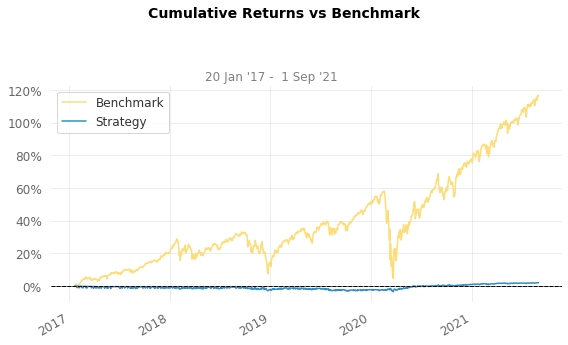

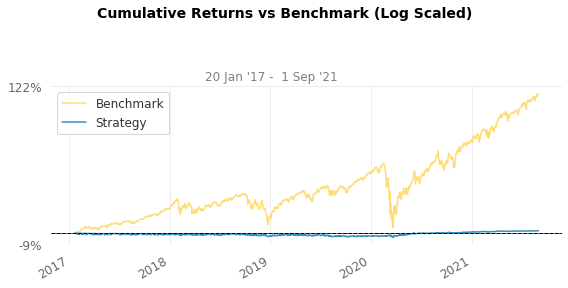

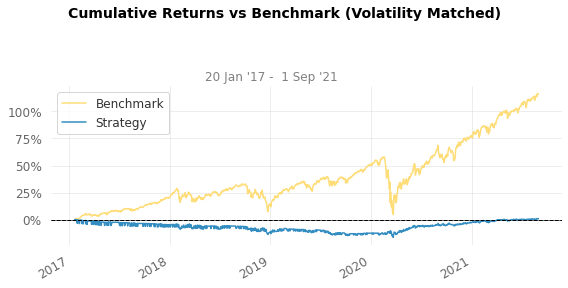

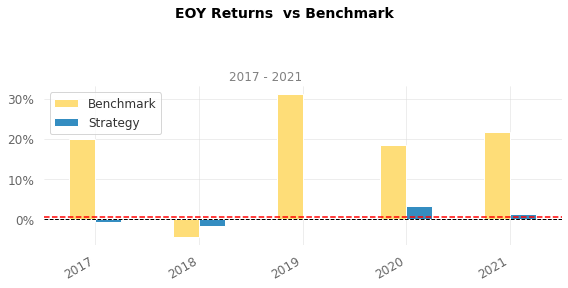

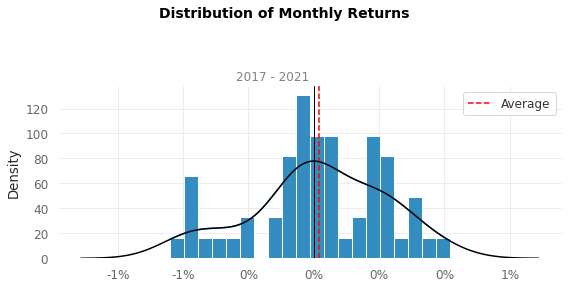

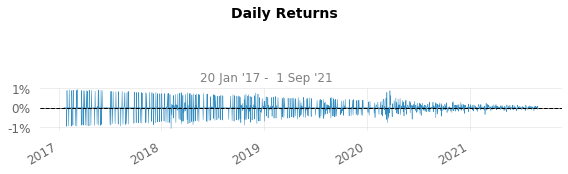

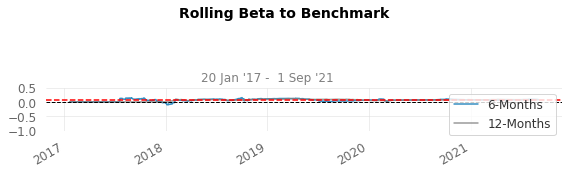

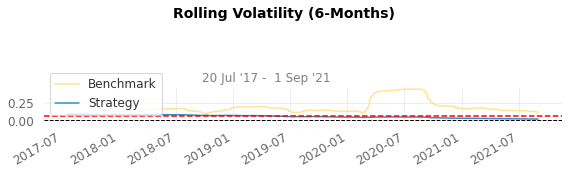

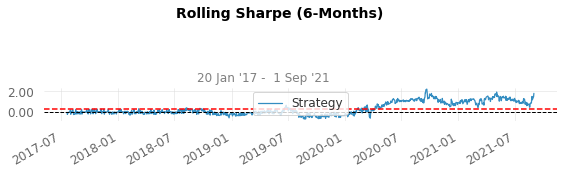

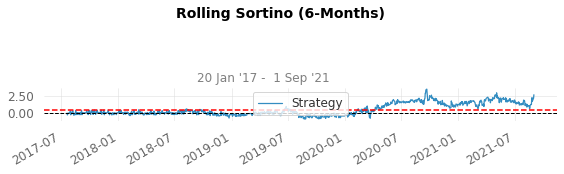

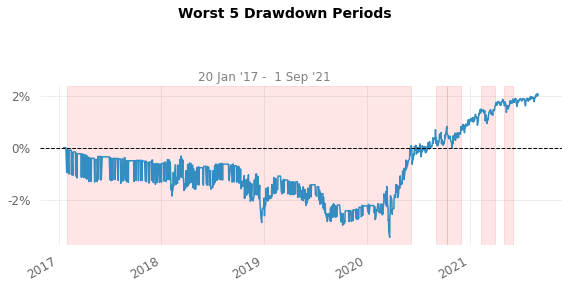

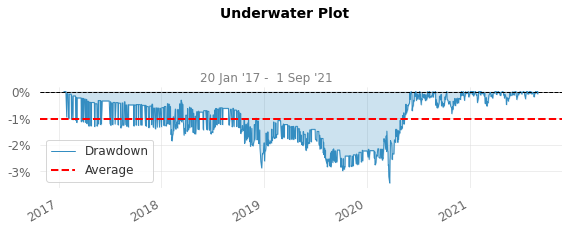

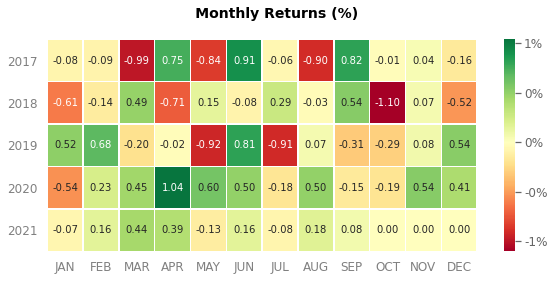

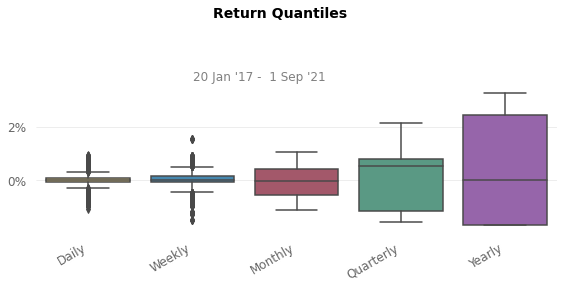

In [259]:
%matplotlib inline
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

returns.index = returns.index.tz_convert(None)
qs.reports.full(returns, "SPY")
#qs.reports.html(returns, "SPY", output='qs.html')